#Instalação de Pacotes

In [1]:
!pip install -q yfinance

#Importar Pacotes

In [2]:

import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

from datetime import date
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import pandas as pd
from pandas.tseries.offsets import BDay
pd.set_option("display.max_colwidth", 150)

import warnings
warnings.filterwarnings("ignore")
from matplotlib import cycler

colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")
plt.rc('figure', facecolor='#313233')

#Exportar para excell

In [3]:
#piores.to_excel(r'C:\Users\Felipe\Desktop\export_dataframe.xlsx', index=False)

#Gráfico

#BACKTESTING CARE

#Dados complilados

In [4]:
#Dados do fundo
f=yf.download("CARE11.SA", start="2017-08-31", end="2024-01-01")
CARE11=f["Adj Close"].pct_change(1)

return_serie = CARE11
return_serie.name = "return"

[*********************100%%**********************]  1 of 1 completed


In [5]:
f

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-08-31,1.80,1.83,1.80,1.80,1.80,14000
2017-09-01,1.80,1.80,1.80,1.80,1.80,0
2017-09-04,1.80,1.80,1.80,1.80,1.80,0
2017-09-05,1.80,1.80,1.80,1.80,1.80,0
2017-09-06,1.80,1.80,1.80,1.80,1.80,0
...,...,...,...,...,...,...
2023-12-21,1.30,1.39,1.30,1.37,1.37,10148
2023-12-22,1.34,1.35,1.33,1.33,1.33,4399
2023-12-26,1.34,1.39,1.33,1.37,1.37,28132


In [6]:
f.to_excel(r'C:\Users\Felipe\Desktop\f.xlsx', index=False)

#Índices Importantes

In [7]:
CARE11

Date
2017-08-31         NaN
2017-09-01    0.000000
2017-09-04    0.000000
2017-09-05    0.000000
2017-09-06    0.000000
                ...   
2023-12-21    0.053846
2023-12-22   -0.029197
2023-12-26    0.030075
2023-12-27    0.000000
2023-12-28    0.000000
Name: return, Length: 1574, dtype: float64

In [8]:
#sortino


# Cálculo do sortino
mean = np.mean(return_serie) #252
vol = np.std(return_serie[return_serie<0]) #sqrt(252)
sortino = np.sqrt(252) * mean/vol

print(f"Sortino: {'%.3f' % sortino}")

Sortino: 1.103


In [9]:
# CovariÂncia entre o mercado e o fundo
f1 = yf.download("BOVA11.SA", start="2017-08-31", end="2020-12-31")
BOVA11=f1["Close"].pct_change(1)


# Concatenar
val = pd.concat((return_serie, BOVA11), axis=1).dropna()

# Calcular Beta
cov_var_mat = np.cov(val.values, rowvar=False)
cov = cov_var_mat[0][1]
var = cov_var_mat[1][1]

beta = cov/var

print(f"Beta: {'%.3f' % beta}")

[*********************100%%**********************]  1 of 1 completed

Beta: 0.264


In [10]:
# Cálculo do alpha
alpha = (252 * mean * (1-beta))*100
print(f"Alpha: {'%.1f' % alpha}")

Alpha: 34.8


In [11]:
def drawdown_function(serie):

  # Máximo dos retornos
  cum = serie.dropna().cumsum() + 1

  # Máximo de ganho do período (accumulate max) # (1,3,5,3,1) --> (1,3,5,5,5)
  running_max = np.maximum.accumulate(cum)

  # cálculo do drawdown
  drawdown = cum/running_max - 1
  return drawdown

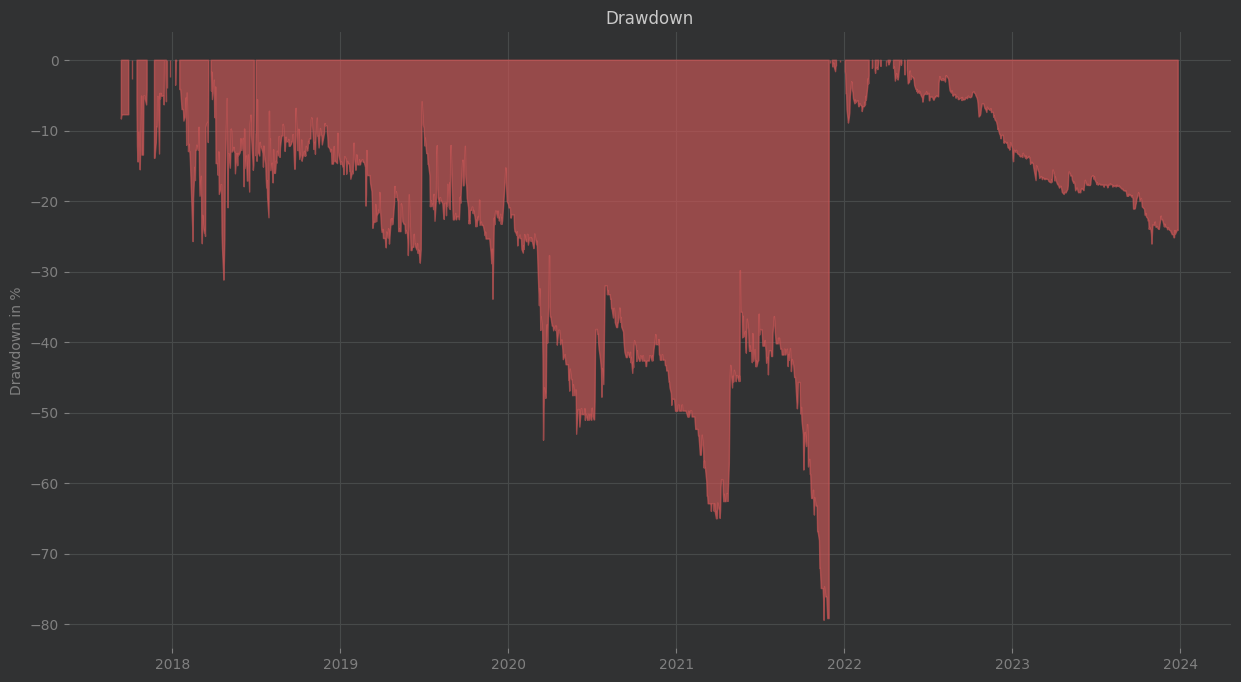

In [12]:
#Cálculo do drawdown
drawdown = drawdown_function(return_serie)

# Tamanho da figura
plt.figure(figsize=(15,8))

# Plotagem do drawdown
plt.fill_between(drawdown.index, drawdown*100, 0,
                 drawdown, color="#CE5757", alpha=0.65)

# Título
plt.title("Drawdown")

# Eixo Y
plt.ylabel("Drawdown in %")

plt.show()

In [13]:
#Função Completa

In [14]:
def BackTest(serie, annualiazed_scalar=252):

  # Mercado
  sp500 = yf.download("BOVA11.SA")["Adj Close"].pct_change(1)

  # Trocar o nome
  sp500.name = "SP500"

  # Concatenar os retornos com o mercado
  val = pd.concat((serie,sp500), axis=1).dropna()
  # Cálculo do drawdown
  drawdown = drawdown_function(serie)*100

  # Computar o drawdown máximo
  max_drawdown = -np.min(drawdown)




  # Subplots
  fig, (cum, dra) = plt.subplots(1,2, figsize=(20,6))

  # Subtítulo
  fig.suptitle("Backtesting", size=20)

  # Soma acumulada dos retornos
  cum.plot(serie.cumsum()*100, color="#39B3C7")

  # SP500/BOVA11 - soma acumulada dos retornos
  cum.plot(val["SP500"].cumsum()*100, color="#B85A0F")

  # Legenda
  cum.legend(["CARE", "Mercado"])

  # Título individual
  cum.set_title("Retorno Acumulado", size=13)

  cum.set_ylabel("Retorno Acumulado %", size=11)

  # Colocar o drawdown
  dra.fill_between(drawdown.index,0,drawdown, color="#C73954", alpha=0.65)

  # Título
  dra.set_title("Drawdown", size=13)

  dra.set_ylabel("drawdown in %", size=11)

  # Plotar o gráfico
  plt.show()


  # Computar o sortino
  sortino = np.sqrt(annualiazed_scalar) * serie.mean()/serie.loc[serie<0].std()

  # Computar o beta
  beta = np.cov(val[["return", "SP500"]].values,rowvar=False)[0][1] / np.var(val["SP500"].values)

  # Computar o alpha
  alpha = annualiazed_scalar * (serie.mean() - beta*serie.mean())

  # Imprimir os índices
  print(f"Sortino: {np.round(sortino,3)}")
  print(f"Beta: {np.round(beta,3)}")
  print(f"Alpha: {np.round(alpha*100,3)} %")
  print(f"MaxDrawdown: {np.round(max_drawdown,3)} %")

[*********************100%%**********************]  1 of 1 completed


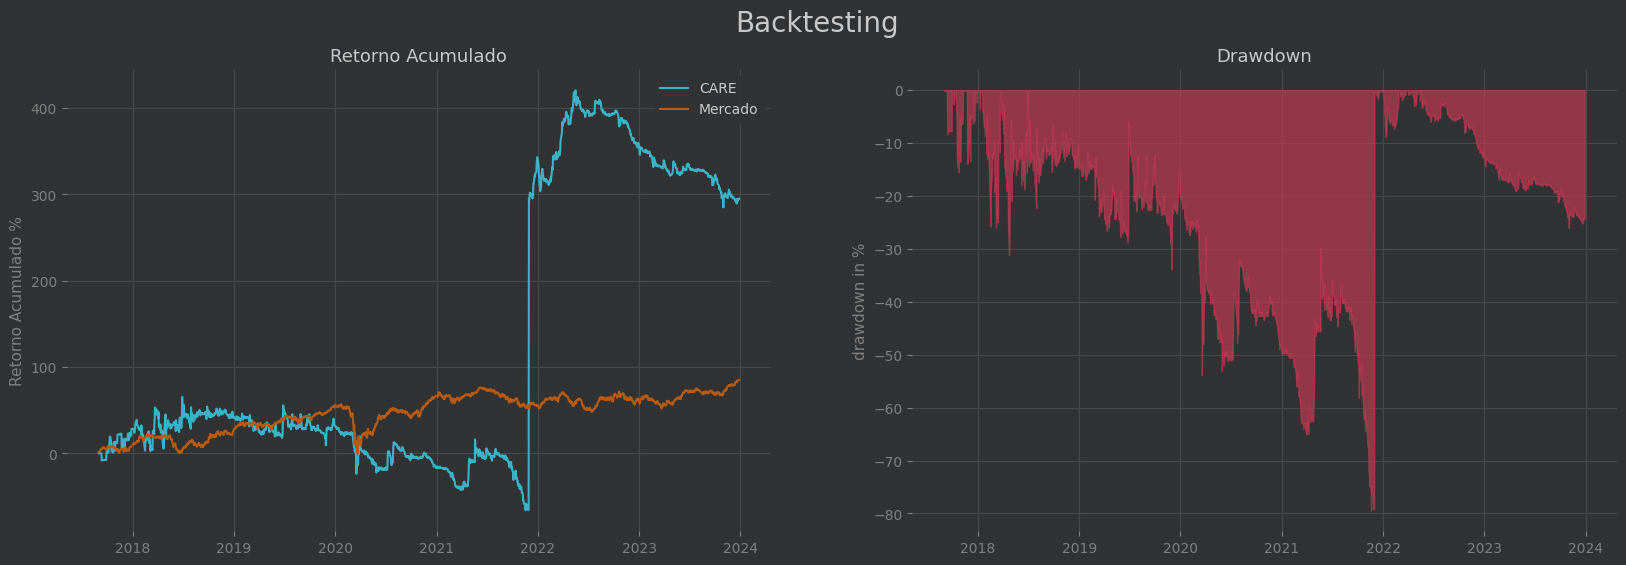

Sortino: 1.103
Beta: 0.195
Alpha: 38.07 %
MaxDrawdown: 79.406 %


In [15]:
BackTest(return_serie, 252)

#Comparando com a SELIC e CDI

In [16]:
def cdi_acumulado(data_inicio, data_fim):
  codigo_bcb = 12

  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  cdi = pd.read_json(url)
  cdi['data'] = pd.to_datetime(cdi['data'], dayfirst=True)
  cdi.set_index('data', inplace=True)

  cdi_acumulado = (1 + cdi[data_inicio : data_fim] / 100).cumprod()
  cdi_acumulado.iloc[0] = 1
  return cdi_acumulado

In [17]:
cdi = cdi_acumulado('2017-08-31', '2024-01-29') * 100
cdi

,valor
data,
2017-08-31,100.000000
2017-09-01,100.069438
2017-09-04,100.104175
2017-09-05,100.138924
2017-09-06,100.173686
...,...
2024-01-23,158.586347
2024-01-24,158.655711
2024-01-25,158.725106


In [18]:
def selic_acumulada(data_inicio, data_fim):
  codigo_bcb = 4390

  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  selic = pd.read_json(url)
  selic['data'] = pd.to_datetime(selic['data'], dayfirst=True)
  selic.set_index('data', inplace=True)

  selic_acumulada = (1 + selic[data_inicio : data_fim] / 100).cumprod()
  selic_acumulada.iloc[0] = 1
  return selic_acumulada

In [19]:
selic= selic_acumulada('2017-08-31', '2024-01-29') * 100
selic

,valor
data,
2017-09-01,100.000000
2017-10-01,101.284096
2017-11-01,101.861415
2017-12-01,102.411467
2018-01-01,103.005453
...,...
2023-09-01,153.052476
2023-10-01,154.583001
2023-11-01,156.005165


In [20]:
cdi

,valor
data,
2017-08-31,100.000000
2017-09-01,100.069438
2017-09-04,100.104175
2017-09-05,100.138924
2017-09-06,100.173686
...,...
2024-01-23,158.586347
2024-01-24,158.655711
2024-01-25,158.725106


In [21]:
selic

,valor
data,
2017-09-01,100.000000
2017-10-01,101.284096
2017-11-01,101.861415
2017-12-01,102.411467
2018-01-01,103.005453
...,...
2023-09-01,153.052476
2023-10-01,154.583001
2023-11-01,156.005165


#CARE

In [22]:
f

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-08-31,1.80,1.83,1.80,1.80,1.80,14000
2017-09-01,1.80,1.80,1.80,1.80,1.80,0
2017-09-04,1.80,1.80,1.80,1.80,1.80,0
2017-09-05,1.80,1.80,1.80,1.80,1.80,0
2017-09-06,1.80,1.80,1.80,1.80,1.80,0
...,...,...,...,...,...,...
2023-12-21,1.30,1.39,1.30,1.37,1.37,10148
2023-12-22,1.34,1.35,1.33,1.33,1.33,4399
2023-12-26,1.34,1.39,1.33,1.37,1.37,28132


#Calcular a rentabilidade do CARE

In [23]:
CARE=f["Adj Close"]

In [24]:
f

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-08-31,1.80,1.83,1.80,1.80,1.80,14000
2017-09-01,1.80,1.80,1.80,1.80,1.80,0
2017-09-04,1.80,1.80,1.80,1.80,1.80,0
2017-09-05,1.80,1.80,1.80,1.80,1.80,0
2017-09-06,1.80,1.80,1.80,1.80,1.80,0
...,...,...,...,...,...,...
2023-12-21,1.30,1.39,1.30,1.37,1.37,10148
2023-12-22,1.34,1.35,1.33,1.33,1.33,4399
2023-12-26,1.34,1.39,1.33,1.37,1.37,28132


In [25]:
f.iloc[0]=1

In [26]:
CARE11

Date
2017-08-31         NaN
2017-09-01    0.000000
2017-09-04    0.000000
2017-09-05    0.000000
2017-09-06    0.000000
                ...   
2023-12-21    0.053846
2023-12-22   -0.029197
2023-12-26    0.030075
2023-12-27    0.000000
2023-12-28    0.000000
Name: return, Length: 1574, dtype: float64

In [27]:
CARE2=1+CARE11

In [28]:
CARE2

Date
2017-08-31         NaN
2017-09-01    1.000000
2017-09-04    1.000000
2017-09-05    1.000000
2017-09-06    1.000000
                ...   
2023-12-21    1.053846
2023-12-22    0.970803
2023-12-26    1.030075
2023-12-27    1.000000
2023-12-28    1.000000
Name: return, Length: 1574, dtype: float64

In [29]:
CARE2.iloc[0]=1

In [30]:
CARE2=CARE2.cumprod


In [31]:
CARE2

<bound method NDFrame._add_numeric_operations.<locals>.cumprod of Date
2017-08-31    1.000000
2017-09-01    1.000000
2017-09-04    1.000000
2017-09-05    1.000000
2017-09-06    1.000000
                ...   
2023-12-21    1.053846
2023-12-22    0.970803
2023-12-26    1.030075
2023-12-27    1.000000
2023-12-28    1.000000
Name: return, Length: 1574, dtype: float64>

In [32]:
CARE2=CARE2*100

TypeError: unsupported operand type(s) for *: 'method' and 'int'

#Gráfico mais requintado (editável com "mommentum"): CARE vs Selic

In [ ]:
import plotly.figure_factory as ff
import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px
import datetime as dt
import plotly.io as pio
pio.templates.default = "seaborn"

In [ ]:
CARE

In [ ]:
  cdi['data'] = pd.to_datetime(cdi['data'], dayfirst=True)
  cdi.set_index('data', inplace=True)

  cdi_acumulado = (1 + cdi[data_inicio : data_fim] / 100).cumprod()
  cdi_acumulado.iloc[0] = 1
  return cdi_acumulado

In [ ]:
trace0 = go.Scatter(x=CARE2, y=CARE2.index, name='Care11', line=dict(color='lime'))
trace1 = go.Scatter(x=selic.index, y=selic.valor, name='Selic', line=dict(color='red'))

fig1 = go.Figure([trace0, trace1])
fig1.update_layout(dict(
    title=dict({
        'text': "Care vs Selic",
        'x':0.0,
        'xanchor': 'center'}),
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=3,
                     label='3m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='12m',
                     step='month',
                     stepmode='backward')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date')))
fig1.show()